<a href="https://colab.research.google.com/github/Uralstech/Qwen-KCC-On-Device-Pipeline/blob/main/notebooks/Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install unsloth

In [ ]:
!rm -rf /content/unsloth_compiled_cache

In [ ]:
!curl -L -o ./farmers-call-query-data-qa.zip https://www.kaggle.com/api/v1/datasets/download/daskoushik/farmers-call-query-data-qa
!unzip farmers-call-query-data-qa.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4613k  100 4613k    0     0  1572k      0  0:00:02  0:00:02 --:--:-- 3465k
Archive:  farmers-call-query-data-qa.zip
  inflating: questionsv4.csv         


In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 32768 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    # Can select any from the below:
    # "unsloth/Qwen2.5-0.5B", "unsloth/Qwen2.5-1.5B", "unsloth/Qwen2.5-3B"
    # "unsloth/Qwen2.5-14B",  "unsloth/Qwen2.5-32B",  "unsloth/Qwen2.5-72B",
    # And also all Instruct versions and Math. Coding verisons!
    model_name = "unsloth/Qwen2.5-1.5B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.12.9: Fast Qwen2 patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.53G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.12.9 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
def formatting_prompts_func(examples):
    instructions = examples["questions"]
    outputs      = examples["answers"]
    texts = []
    for instruction, output in zip(instructions, outputs):
        texts.append(tokenizer.apply_chat_template([
            {"role": "user", "content": instruction},
            {"role": "assistant", "content": output}
        ], tokenize=False))
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("csv", data_files="./questionsv4.csv", encoding="macroman")


def valid_qa(example):
    q = example["questions"]
    a = example["answers"]
    return (
        q is not None and a is not None and
        str(q).strip() != "" and str(a).strip() != ""
    )

dataset = dataset.filter(valid_qa)

dataset = dataset.map(formatting_prompts_func, batched = True,)
dataset = dataset.remove_columns(["questions", "answers"])
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/178939 [00:00<?, ? examples/s]

Map:   0%|          | 0/178815 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 178815
    })
})


In [ ]:
# ────────────────────────────────────────────────────────────────
#  IMPORTANT IMPORTS
# ────────────────────────────────────────────────────────────────
from unsloth import FastLanguageModel, is_bfloat16_supported
from trl import SFTTrainer, SFTConfig
import torch
import os

# Optional: clear Unsloth's compilation cache to force clean recompile
# (helps avoid stale buggy trainer files)
!rm -rf /content/unsloth_compiled_cache/

# ────────────────────────────────────────────────────────────────
#  TRAINER CONFIGURATION
# ────────────────────────────────────────────────────────────────
max_seq_length = 32768  # must match what you used when loading the model

trainer = SFTTrainer(
    model                     = model,
    tokenizer                 = tokenizer,

    train_dataset             = dataset['train'],          # your training split
    # eval_dataset            = dataset.get('validation'), # optional

    dataset_text_field        = "text",                    # column with formatted text
    max_seq_length            = max_seq_length,

    dataset_num_proc          = 1,                         # ← Critical: avoids psutil NameError in compiled trainer
    packing                   = False,                     # usually safer with Qwen + long context

    args = SFTConfig(
        # Core training settings
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,                   # effective batch size = 2 × 4 = 8
        warmup_steps                = 5,
        max_steps                   = 60,                  # for quick testing – change to 300–1000+ later
        # num_train_epochs          = 1,                   # alternative to max_steps

        # Optimizer & schedule
        learning_rate               = 2e-4,
        optim                       = "adamw_8bit",
        weight_decay                = 0.01,
        lr_scheduler_type           = "linear",

        # Precision (Unsloth usually handles this well)
        fp16                        = not is_bfloat16_supported(),
        bf16                        = is_bfloat16_supported(),

        # Logging & output
        logging_steps               = 1,
        seed                        = 3407,
        output_dir                  = "outputs_qwen25_1.5b",
        report_to                   = "none",              # change to "wandb" / "tensorboard" if desired

        # Memory optimizations (very important on Colab)
        gradient_checkpointing      = True,
        remove_unused_columns       = False,

        # Optional but helpful
        save_strategy               = "steps",
        save_steps                  = 20,
        save_total_limit            = 3,
    ),
)

# ────────────────────────────────────────────────────────────────
#  PRINT TRAINING SUMMARY & START
# ────────────────────────────────────────────────────────────────
print("Trainer device:", trainer.args.device)
print("Effective batch size:", trainer.args.per_device_train_batch_size * trainer.args.gradient_accumulation_steps)
print("Max steps:", trainer.args.max_steps)
print("Output will be saved to:", trainer.args.output_dir)

# Start training
trainer_stats = trainer.train()

# Optional: save final LoRA adapters
model.save_pretrained("lora_qwen25_1.5b_final")
tokenizer.save_pretrained("lora_qwen25_1.5b_final")

# Optional: push to Hugging Face (uncomment if logged in)
# model.push_to_hub("your-username/qwen2.5-1.5b-instruct-lora-v1")
# tokenizer.push_to_hub("your-username/qwen2.5-1.5b-instruct-lora-v1")

Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/178815 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


🦥 Unsloth: Padding-free auto-enabled, enabling faster training.
Trainer device: cuda:0
Effective batch size: 8
Max steps: 60
Output will be saved to: outputs_qwen25_1.5b


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 178,815 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 18,464,768 of 1,562,179,072 (1.18% trained)


Step,Training Loss
1,5.535300
2,5.617600
3,4.821100
4,4.478700
5,4.340200
6,3.742200
7,3.089400
8,2.933000
9,2.678000
10,2.297400


Unsloth: Will smartly offload gradients to save VRAM!


('lora_qwen25_1.5b_final/tokenizer_config.json',
 'lora_qwen25_1.5b_final/special_tokens_map.json',
 'lora_qwen25_1.5b_final/chat_template.jinja',
 'lora_qwen25_1.5b_final/vocab.json',
 'lora_qwen25_1.5b_final/merges.txt',
 'lora_qwen25_1.5b_final/added_tokens.json',
 'lora_qwen25_1.5b_final/tokenizer.json')

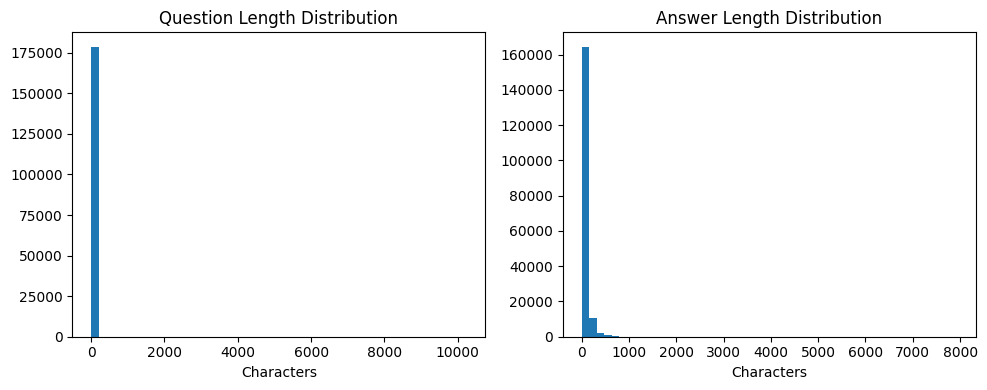

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("questionsv4.csv", encoding="macroman")

df = df[
    df["questions"].notna() & df["answers"].notna() &
    (df["questions"].str.strip() != "") &
    (df["answers"].str.strip() != "")
]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(df["questions"].str.len(), bins=50)
plt.title("Question Length Distribution")
plt.xlabel("Characters")

plt.subplot(1,2,2)
plt.hist(df["answers"].str.len(), bins=50)
plt.title("Answer Length Distribution")
plt.xlabel("Characters")

plt.tight_layout()
plt.savefig("fig_qa_length_characters.png", dpi=600)
plt.show()


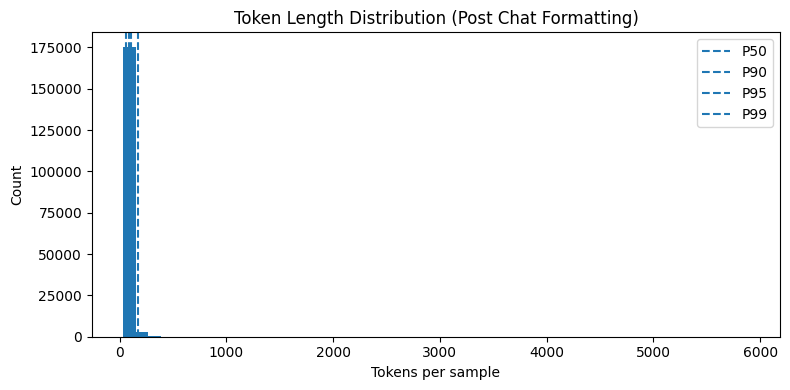

In [ ]:
import numpy as np

def token_length(text):
    return len(tokenizer(text).input_ids)

token_lengths = [
    token_length(t) for t in dataset["train"]["text"]
]

plt.figure(figsize=(8,4))
plt.hist(token_lengths, bins=50)
plt.xlabel("Tokens per sample")
plt.ylabel("Count")
plt.title("Token Length Distribution (Post Chat Formatting)")

for p in [50, 90, 95, 99]:
    plt.axvline(
        np.percentile(token_lengths, p),
        linestyle="--",
        label=f"P{p}"
    )

plt.legend()
plt.tight_layout()
plt.savefig("fig_token_length_distribution.png", dpi=600)
plt.show()


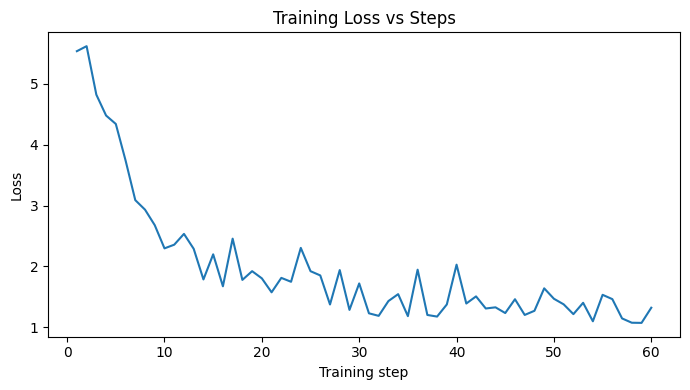

In [ ]:
import pandas as pd

log_history = trainer.state.log_history
df_logs = pd.DataFrame(log_history)

loss_df = df_logs[df_logs["loss"].notna()]

plt.figure(figsize=(7,4))
plt.plot(loss_df["step"], loss_df["loss"])
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training Loss vs Steps")
plt.tight_layout()
plt.savefig("fig_training_loss.png", dpi=600)
plt.show()


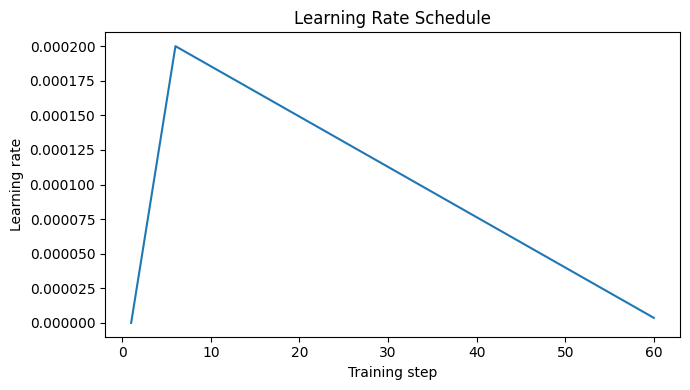

In [ ]:
lr_df = df_logs[df_logs["learning_rate"].notna()]

plt.figure(figsize=(7,4))
plt.plot(lr_df["step"], lr_df["learning_rate"])
plt.xlabel("Training step")
plt.ylabel("Learning rate")
plt.title("Learning Rate Schedule")
plt.tight_layout()
plt.savefig("fig_lr_schedule.png", dpi=600)
plt.show()


In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
2.736 GB of memory reserved.


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

139.0516 seconds used for training.
2.32 minutes used for training.
Peak reserved memory = 2.736 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 18.56 %.
Peak reserved memory for training % of max memory = 0.0 %.


In [ ]:
# Enable optimized inference (important)
FastLanguageModel.for_inference(model)

# Build messages in chat format
messages = [
    {"role": "user", "content": "asking about the control measure of flower drop problem in his coconut plant"}
]

# Apply chat template
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
).to("cuda")

# Generate
outputs = model.generate(
    inputs,
    max_new_tokens=64,
    use_cache=True,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
)

# Decode
response = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(response[0])


system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
asking about the control measure of flower drop problem in his coconut plant
assistant
suggested to apply 2% malathion @ spray at fortnightly interval for controlling the disease


In [ ]:
model.save_pretrained_merged("./Qwen-2.5-1.5B-KCC", tokenizer);


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files: 100%|██████████| 1/1 [01:09<00:00, 69.32s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [01:22<00:00, 82.71s/it]


Unsloth: Merge process complete. Saved to `/content/Qwen-2.5-1.5B-KCC`


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r ./Qwen-2.5-1.5B-KCC ./drive/MyDrive/